In [1]:
%pylab inline
%autosave 20
import os
os.environ['KERAS_BACKEND']='theano'
import keras
import sys
sys.path.append('/home/peter')
sys.path.append('/home/peter/code/projects/MultiNEAT')
sys.path.append('/home/ubuntu')
from universal import *
sys.path.append('/home/peter/code/projects')
sys.path.append('/home/peter/code/projects/deepneat')
sys.path.append('/home/ubuntu')
sys.path.append('/home/ubuntu/new/automl')
from aidevutil import *
from keras.utils.vis_utils import plot_model
from tqdm import tqdm_notebook as tqdm
from deepneat import *

Populating the interactive namespace from numpy and matplotlib


Autosaving every 20 seconds


Using Theano backend.
Using cuDNN version 7103 on context None
Mapped name None to device cuda: GeForce GTX 1050 with Max-Q Design (0000:02:00.0)


vizdoom could not be imported
Pixiedust database opened successfully


In [2]:
from dask import compute, delayed, persist
from dask.distributed import Client, wait
from dask.distributed import as_completed

In [3]:
import ipywidgets as widgets

In [4]:
(x_train, y_train), (x_test, y_test) = get_mnist(size=(28,28), nrows=1000, nrows_test=1000)
dx = x_train.reshape(x_train.shape[0], -1)
dy = y_train.reshape(-1, 1)

dx_test = x_test.reshape(x_test.shape[0], -1)

In [5]:
dx.shape, dy.shape

((1000, 784), (1000, 1))

In [6]:
dx.shape, dy.shape

((1000, 784), (1000, 1))

In [7]:
###################
# Prototype Nodes #
###################
#
# Linear, PCA
#
# LogisticRegression
#
#

In [8]:
# NEAT Parameters 
params = NEAT.Parameters()

params.PopulationSize = 300
params.DynamicCompatibility = True
params.YoungAgeTreshold = 3
params.SpeciesMaxStagnation = 10
params.OldAgeTreshold = 10
params.MinSpecies = 1
params.MaxSpecies = 12
params.RouletteWheelSelection = False
params.ArchiveEnforcement = False
params.InnovationsForever = True

params.ConstraintTrials = 128

params.MutateAddNeuronProb = 0.15/3
params.MutateAddLinkProb = 0.5/3
params.MutateRemLinkProb = 0.1/3
params.RecurrentProb = 0.0
params.MaxWeight = 1.0

params.MutateWeightsProb = 0.0
params.MutateActivationAProb = 0.0
params.MutateActivationBProb = 0.0
params.MutateNeuronTimeConstantsProb = 0.0
params.MutateNeuronBiasesProb = 0.0

params.MutateGenomeTraitsProb = 0.0
params.MutateNeuronTraitsProb = 0.5
params.MutateLinkTraitsProb = 0.0

params.OverallMutationRate = 0.5
params.CrossoverRate = 0.7
params.MultipointCrossoverRate = 0.4
params.SurvivalRate = 0.2
params.InterspeciesCrossoverRate = 0.005
params.PreferFitterParentRate = 0.5

params.DontUseBiasNeuron = True
params.AllowLoops = False
params.AllowClones = True

params.ExcessCoeff = 1.0
params.DisjointCoeff = 1.0

params.WeightDiffCoeff = 0.0
params.TimeConstantDiffCoeff = 0.0
params.BiasDiffCoeff = 0.0
params.ActivationADiffCoeff = 0.0
params.ActivationBDiffCoeff = 0.0
params.NormalizeGenomeSize = True

params.MinCompatTreshold = 0.0
params.CompatTreshold = 1.25
params.CompatTreshChangeInterval_Evaluations = 1
params.CompatTresholdModifier = 0.002

In [9]:
# This is the custom trait
class BaseObject:
    def __init__(self):
        pass
        
    def mate(self, other):
        baby = BaseObject()
        return baby
    
    def mutate(self):
        baby = BaseObject()
        return baby
    
    def distance_to(self, other):
        return rnd.uniform(0,1)
    
    def conc_inputs(self, mm, inputs):
        if (mm=='concat') or (len(inputs)==1):
            if len(inputs)==1:
                return inputs
            else:
                return np.concatenate(inputs)
        else:
            if mm=='add':
                return np.sum()
    
    # what every object has to do - transform x, possibily changing the number of columns
    # if necessary, fit to data (note: undeterministic!)
    def tick(self, x, y):
        return np.array(x)

In [10]:
class genePCA(BaseObject):
    def __init__(self):
        self.ndim = rnd.randint(2, 16)
        self.pca = PCA(n_components=self.ndim)
        
    def __repr__(self):
        return "PCA(%d)" % self.ndim
    
    def mate(self, other):
        if isinstance(other, genePCA):
            baby = genePCA()
            baby.ndim = (self.ndim + other.ndim)//2
            baby.pca = PCA(n_components=baby.ndim)
            return baby
        else:
            return rnd.choice([self, other])
    
    def mutate(self):
        baby = genePCA()
        baby.ndim += rnd.randint(-3, 3)
        baby.ndim = np.clip(baby.ndim, 2, 16)
        baby.pca = PCA(n_components=baby.ndim)
        return baby
    
    def distance_to(self, other):
        if isinstance(other, genePCA):
            return float(np.abs(self.ndim - other.ndim))
        else:
            return 100000.0
    
    def tick(self, x, y):
        xt = self.pca.fit_transform(x)
        return np.array(xt)
        

In [11]:
class geneLinear(BaseObject):
    def __init__(self):
        pass
    
    def __repr__(self):
        return "Linear"
    
    def mate(self, other):
        return self
    
    def mutate(self):
        return self
    
    def distance_to(self, other):
        return 0
    
    def tick(self, x, y):
        return np.array(x)

In [12]:
from sklearn.linear_model import LogisticRegression

class geneLogisticRegression(BaseObject):
    def __init__(self):
        self.clf = LogisticRegression()
        
    def __repr__(self):
        return "LogReg"
    
    def mate(self, other):
        return self
    
    def mutate(self):
        return self
    
    def distance_to(self, other):
        return 0
    
    def tick(self, x, y):
        self.clf.fit(x, y)
        return self.clf.predict(x)

In [13]:
derived_list = [genePCA, geneLinear, geneLogisticRegression]
probs = [1.0]*len(derived_list)

In [14]:
# Set traits

In [15]:
# merge mode
s = ['concat',
    # when dimensions match, these can be done, otherwise it defaults to concat
     'add','mul','avg','min','max',
    ]
p = [1.0] * len(s)
mm = {'details': {'set': s, 'probs': p},
      'importance_coeff': 0.0,
      'mutation_prob': 0.3,
      'type': 'str'}

params.SetNeuronTraitParameters('mm', mm)

In [16]:
node = {'details': (derived_list, probs),
          'importance_coeff': 0.1,
          'mutation_prob': 0.2,
          'type': 'pyclassset'}

params.SetNeuronTraitParameters('node', node)

In [17]:
num_inputs = 1
num_outputs = 1

In [18]:
num_input_dims = dx.shape[1]
num_output_dims = 1

In [19]:
g = NEAT.Genome(0, num_inputs, 1, num_outputs, 0, NEAT.ActivationFunction.RELU,
                    NEAT.ActivationFunction.RELU, 0, params, 0, 1)

In [20]:
pop = NEAT.Population(g, params, True, 1.0, 0)
pop.RNG.Seed(int(time.clock()*100))

In [21]:
gr = NEAT.Genome2NX(pop.Species[0].Individuals[1])

In [22]:
gr.nodes(data=1)

[(1, {}), (2, {'mm': 'avg', 'node': LogReg})]

In [23]:
def activate_graph(gr, inputs, targets, num_outputs=1):
    allnodes = list(nx.dfs_postorder_nodes(gr))[::-1]
    for a in allnodes: gr.node[a]['act'] = None
    
    # separate input from non-input nodes
    #onlyinputs = sorted([x for x in allnodes if x <= num_inputs], reverse=True)
    allnodes = [x for x in allnodes if x > num_inputs]
    
    # input the data
    for i,inp in zip(range(1, num_inputs+1), inputs): 
        gr.node[i]['act'] = inp
        
    # pass through the graph
    for an in allnodes:
        #print(gr.node[a], end=' ')
        mm = gr.node[an]['mm']
        
        # collect the inputs to this node
        
        # also sort the incoming edges by id for consistency
        inedg = list(gr.in_edges(an))
        #inedg = sorted(inedg, key = lambda x: x[0])
        inps = [gr.node[i]['act'] for i,o in inedg]
        
        if 1: # todo: if mm == ... : 
            if len(inps)>1:
                iii = np.concatenate(inps, axis=1)
            else:
                if isinstance(inps, list):
                    iii = inps[0]
                else:
                    iii = inps
            act = gr.node[an]['node'].tick(iii, targets)
        
        # store activation
        gr.node[an]['act'] = act 
        
    #print('act:', act)
    outputs = [gr.node[o]['act'] for o in allnodes[-num_outputs:]]
    return np.array(outputs)

In [24]:
a = activate_graph(gr, [dx], dy)[0]
a

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
       9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
       5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9,
       9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
       9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8,
       3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5,
       2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6,
       3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
       9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9,
       6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8,

In [25]:
# evaluation function

def evaluate(args):
    idx, gr, dx, dy = args
    
    print(args)
    f = rnd.uniform(0,1)
    
    return idx, f

def decide(x):
    return 100000000.0-x

In [26]:
if socket.gethostname() == 'laptop':
    cluster='192.168.0.108:8786'
elif socket.gethostname() == 'desktop':
    clsuter='192.168.0.108:8786'
else:
    cluster='172.31.43.76:8786'

In [27]:
import time
st = time.time()
print('Connecting..')
if cluster:
    client = Client(cluster)
else:
    client = Client()
# push the data to the cluster
print('Scattering data to cluster..')
debugxy=1
if not debugxy:
    fx = client.scatter(dx, broadcast=True, direct=True)
    fy = client.scatter(dy, broadcast=True, direct=True)
else:
    fx, fy = None, None
print(f'done in {time.time()-st} seconds')

Connecting..
Scattering data to cluster..
done in 0.07833504676818848 seconds


In [28]:
#evaluate((0, NEAT.Genome2NX(pop.Species[0].Individuals[2]), dx, dy))

In [29]:
display_whole_pop = 0
display_max_species = 8
initeval = 0
evaluations = 10000
display_pop_each = 80000
once = False
x_shape, ys = dx.shape[1], 1
population = params.PopulationSize

penalize_stangation = 1
penalize_stagnation_evals = 2400

evhist = []
best_ever = 0
best_gs = []

In [30]:
def poplen(pop):
    return sum([len(x.Individuals) for x in pop.Species])

In [31]:
def prettydict(d, nonl=False):
    i,t,di = d
    if not nonl:
        ks = '%d - %s: ' % (i, t)
    else:
        return '%d - %s' % (i, t)
    s = []
    for k,v in sorted(list(di.items())):
        if isinstance(v, float):
            s.append( '%s %3.3f' % (k[0:1], v) )
        else:
            s.append( '%s %s' % (k[0:1], v) )
    return ks + ', '.join(s)

In [32]:
def species_display(pop):
    genomes = [x.GetLeader() for x in pop.Species][0:display_max_species]
    f, axes = plt.subplots(1, len(genomes), figsize=(len(genomes) * 4.5, 14))
    print('Species Representatives:')
    if len(genomes)>1:
        for i,(ax, g) in enumerate(zip(axes, genomes)):
            try:
                img = NEAT.viz.Draw(g, size=(300, 400))[:, 0:230]
                ax.imshow(img)
                ax.set_title('%3.6f | %3.2f%%' % (decide(g.GetFitness()),
                                                  (len(pop.Species[i].Individuals)/poplen(pop))*100 ))
                s = '\n'.join([prettydict(x) for x in g.GetNeuronTraits() if x[1] != 'input'][0:8])
                s += '\n=============\n'
                s += '\n'.join([prettydict(x, nonl=True) for x in g.GetLinkTraits(False)][0:8])
                ax.set_xlabel(s)
            except Exception as ex:
                print(ex)
    else:
        try:
            g = pop.GetBestGenome()
            img = NEAT.viz.Draw(g, size=(300, 400))[:, 0:230]
            axes.imshow(img)
            axes.set_title('%3.6f' % (decide(g.GetFitness())))
            s = '\n'.join([prettydict(x) for x in g.GetNeuronTraits() if x[1] != 'input'][0:8])
            s += '\n=============\n'
            s += '\n'.join([prettydict(x, nonl=True) for x in g.GetLinkTraits(False)][0:8])
            axes.set_xlabel(s)
        except Exception as ex:
            print(ex)
    f.tight_layout()
    plt.show()

NEW RECORD!
Evaluations: 0 Fitness: 99999999.99900301 Species: 3
-------- nodes -------- 
[2, 'output', {'mm': 'avg', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, -4.959432171890512]
----------------------- 
Species Representatives:


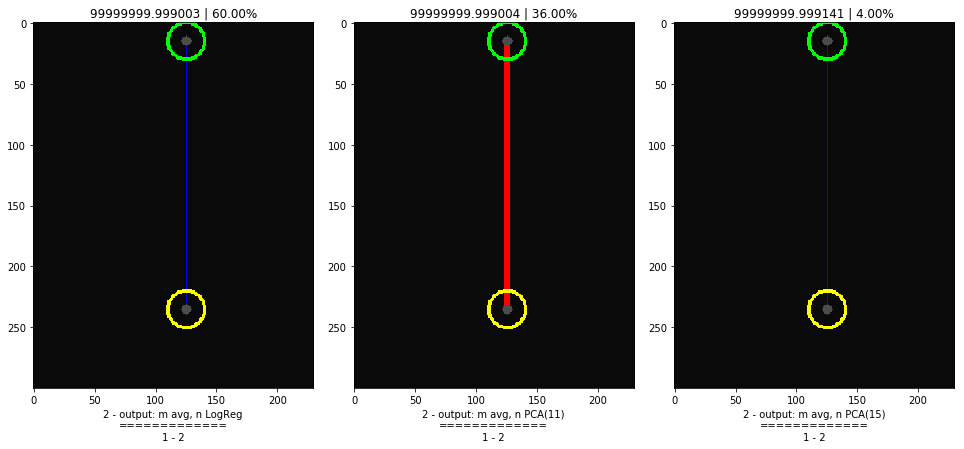

rtNEAT phase
NEW RECORD!
Evaluations: 1 Fitness: 99999999.97987166
-------- nodes -------- 
[2, 'output', {'mm': 'max', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, -3.0606784792616963]
----------------------- 
Species Representatives:


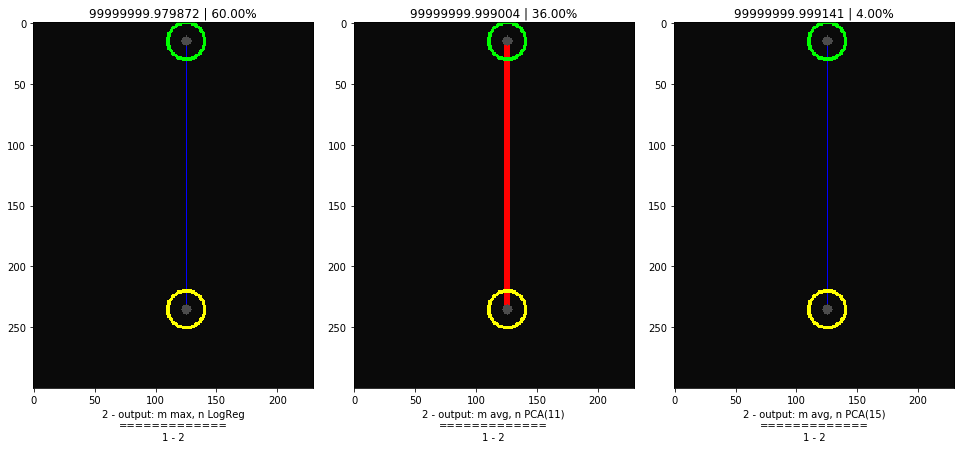

Evaluated: 0 CTresh: 1.250 Species: 3 Last fitness: 99999999.980 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:00) /  0.0 s/individuals

NEW RECORD!
Evaluations: 2 Fitness: 99999999.90617512
-------- nodes -------- 
[2, 'output', {'mm': 'avg', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, -3.7010139951016754]
----------------------- 
Species Representatives:


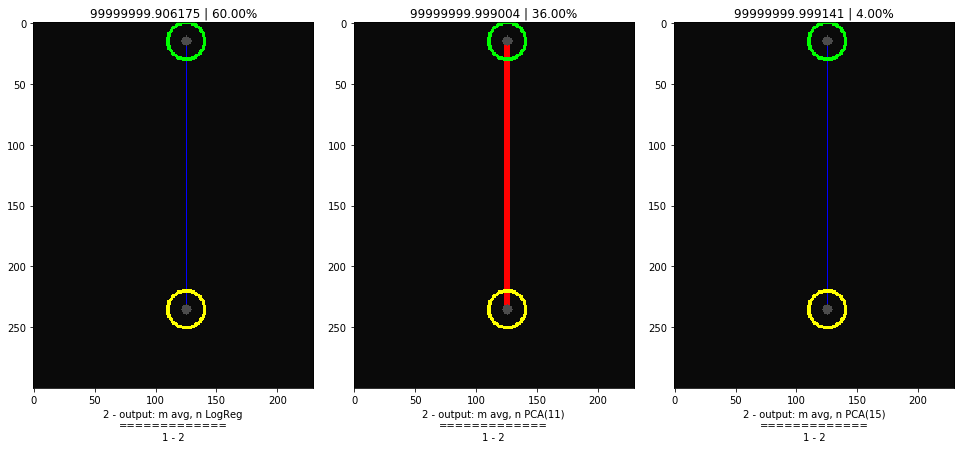

Evaluated: 2 CTresh: 1.250 Species: 3 Last fitness: 99999999.906 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:00) -  4.1 individuals/s

NEW RECORD!
Evaluations: 3 Fitness: 99999999.48261222
-------- nodes -------- 
[2, 'output', {'mm': 'min', 'node': Linear}]
-------- links -------- 
[1, 2, {}, -0.16989069269038737]
----------------------- 
Species Representatives:


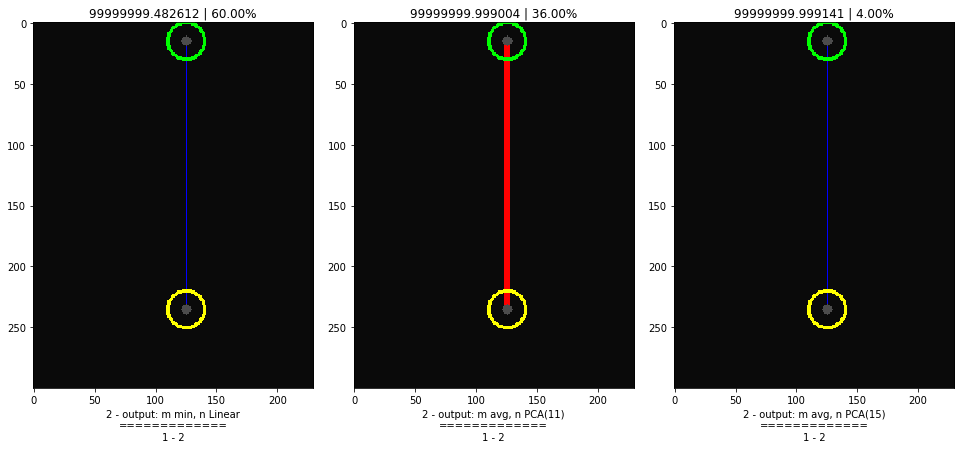

Evaluated: 3 CTresh: 1.250 Species: 3 Last fitness: 99999999.483 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:01) \  3.0 individuals/s

NEW RECORD!
Evaluations: 5 Fitness: 99999999.0362372
-------- nodes -------- 
[2, 'output', {'mm': 'avg', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, 0.49373267753981054]
----------------------- 
Species Representatives:


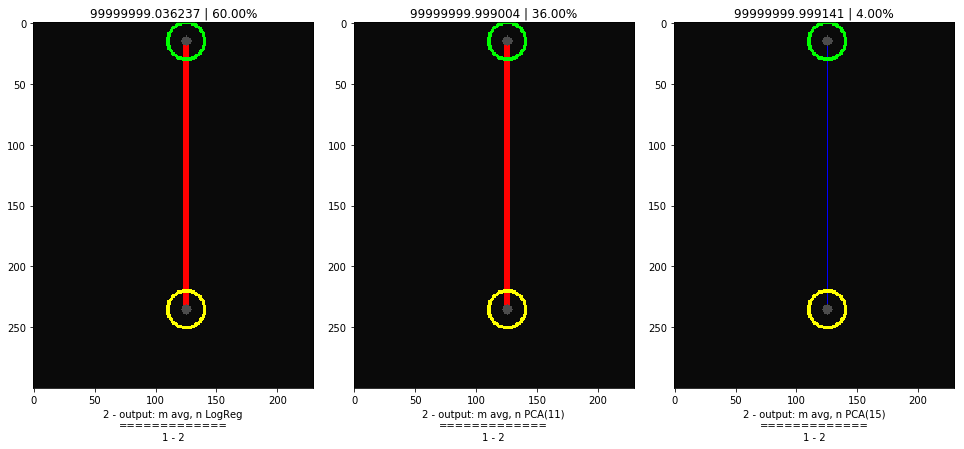

Evaluated: 25 CTresh: 1.250 Species: 3 Last fitness: 99999999.877 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:01) \ 13.0 individuals/s

NEW RECORD!
Evaluations: 27 Fitness: 99999999.03188956
-------- nodes -------- 
[2, 'output', {'mm': 'avg', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, -0.9471682903822511]
----------------------- 
Species Representatives:


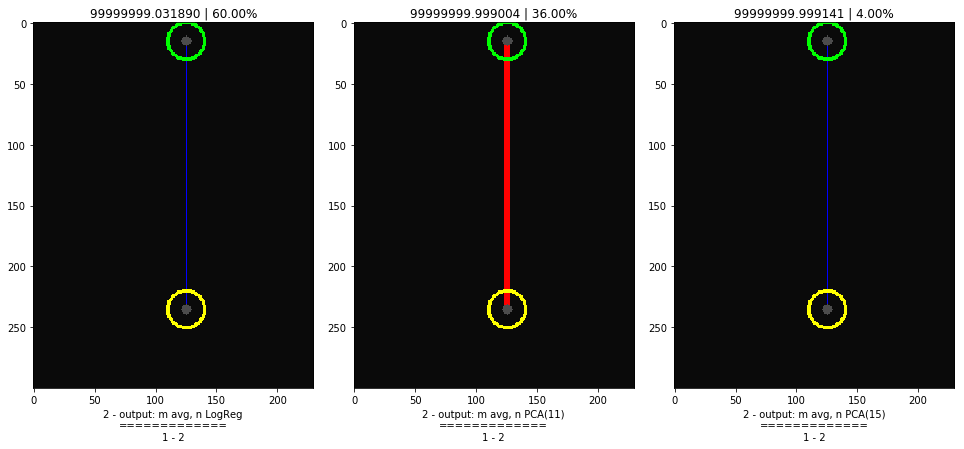

Evaluated: 55 CTresh: 1.250 Species: 3 Last fitness: 99999999.370 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:02) | 19.1 individuals/s

NEW RECORD!
Evaluations: 61 Fitness: 99999999.02040873
-------- nodes -------- 
[2, 'output', {'mm': 'avg', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, -7.613682259107009]
----------------------- 
Species Representatives:


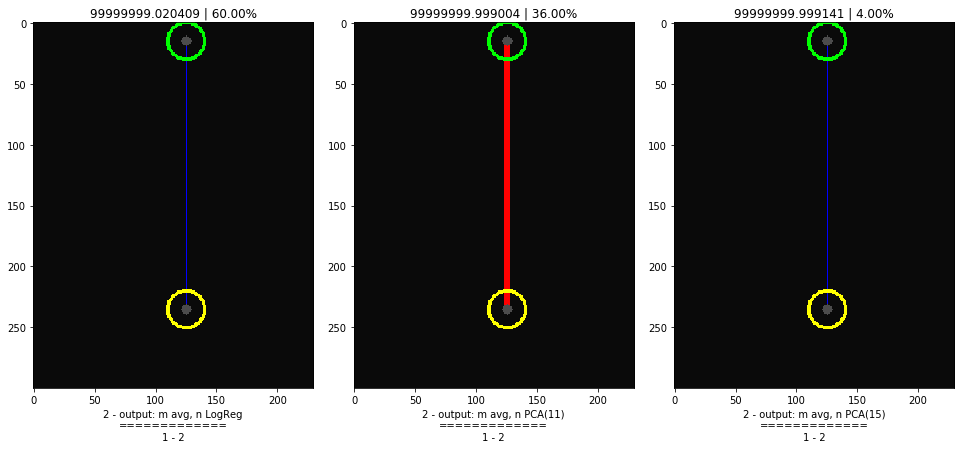

Evaluated: 83 CTresh: 1.250 Species: 3 Last fitness: 99999999.326 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:03) - 20.9 individuals/s

NEW RECORD!
Evaluations: 87 Fitness: 99999999.01372942
-------- nodes -------- 
[2, 'output', {'mm': 'min', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, 0.7908576061017811]
----------------------- 
Species Representatives:


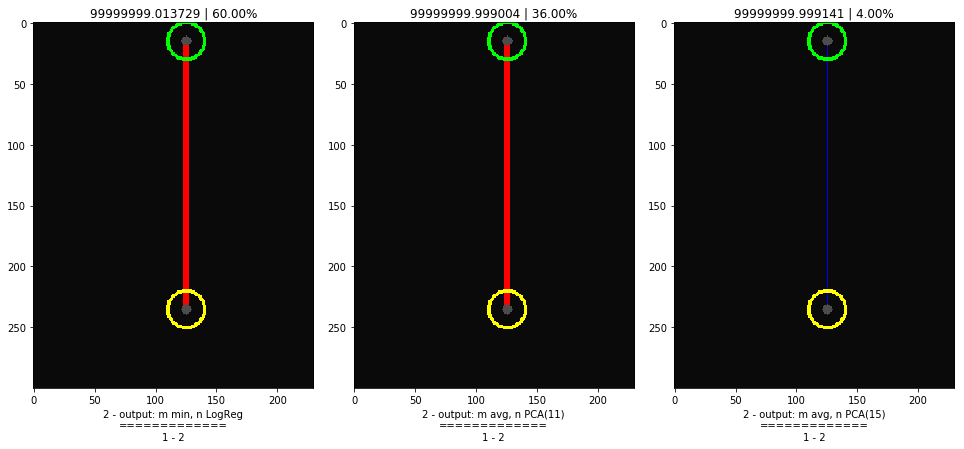

Evaluated: 103 CTresh: 1.250 Species: 3 Last fitness: 99999999.579 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:04) - 21.4 individuals/s

NEW RECORD!
Evaluations: 108 Fitness: 99999999.0090679
-------- nodes -------- 
[2, 'output', {'mm': 'avg', 'node': LogReg}]
-------- links -------- 
[1, 2, {}, -5.967720391694456]
----------------------- 
Species Representatives:


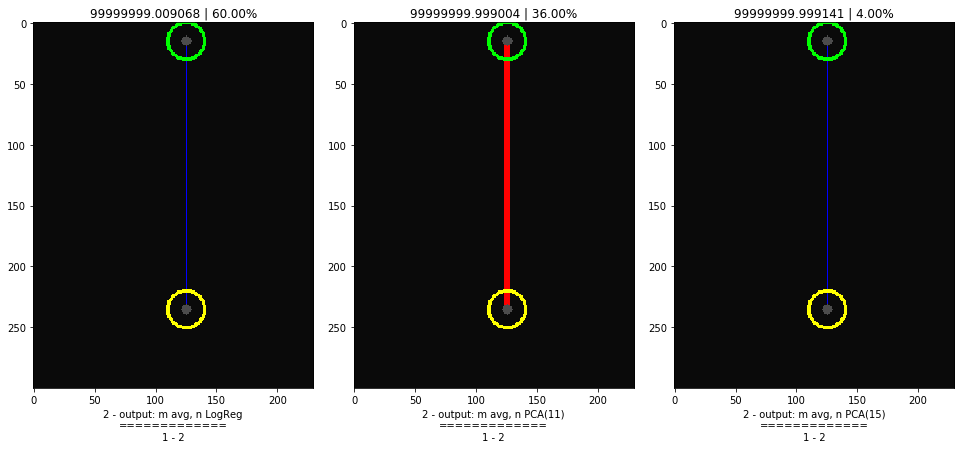

Evaluated: 189 CTresh: 1.250 Species: 3 Last fitness: 99999999.683 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:06) | 27.9 individuals/s

NEW RECORD!
Evaluations: 193 Fitness: 99999999.008352
-------- nodes -------- 
[2, 'output', {'mm': 'mul', 'node': PCA(13)}]
-------- links -------- 
[1, 2, {}, -6.960641364334151]
----------------------- 
Species Representatives:


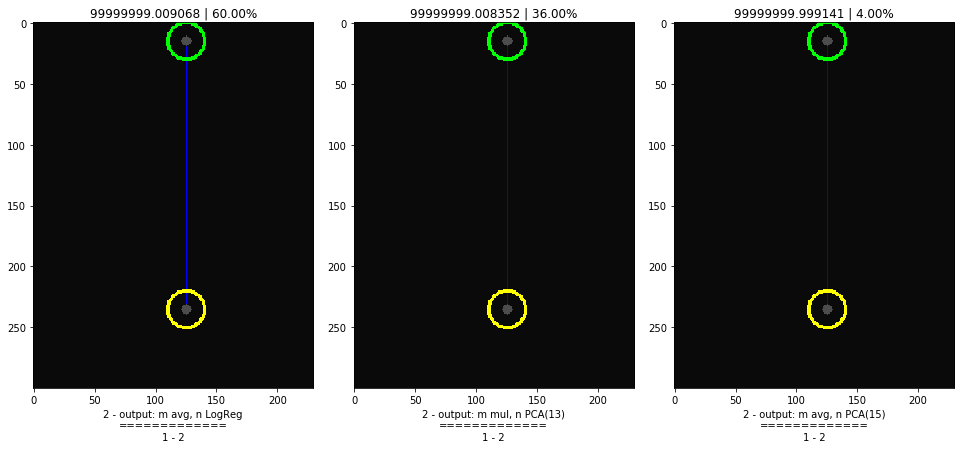

Evaluated: 204 CTresh: 1.250 Species: 3 Last fitness: 99999999.540 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:07) \ 27.0 individuals/s

rtNEAT reproduction cycle started at evaluation #200


Evaluated: 721 CTresh: 1.250 Species: 6 Last fitness: 99999999.801 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:21) - 33.0 individuals/s

NEW RECORD!
Evaluations: 722 Fitness: 99999999.0070251
-------- nodes -------- 
[2, 'output', {'mm': 'min', 'node': PCA(11)}]
-------- links -------- 
[1, 2, {}, 0.1]
----------------------- 
Species Representatives:


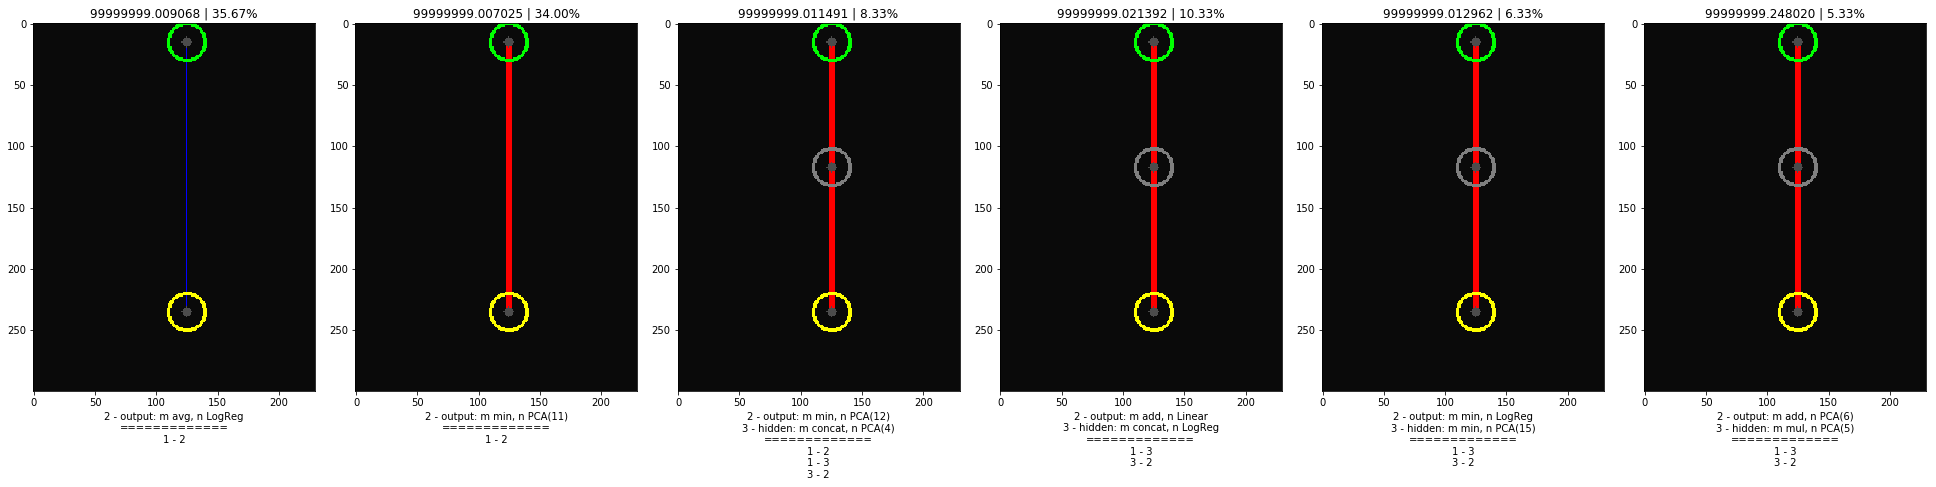

Evaluated: 811 CTresh: 1.250 Species: 6 Last fitness: 99999999.635 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:25) - 31.7 individuals/s

NEW RECORD!
Evaluations: 814 Fitness: 99999999.00189199
-------- nodes -------- 
[2, 'output', {'mm': 'min', 'node': LogReg}]
[3, 'hidden', {'mm': 'min', 'node': PCA(15)}]
-------- links -------- 
[1, 2, {}, 0.1]
[1, 3, {}, 0.1]
[3, 2, {}, 0.1]
----------------------- 
Species Representatives:


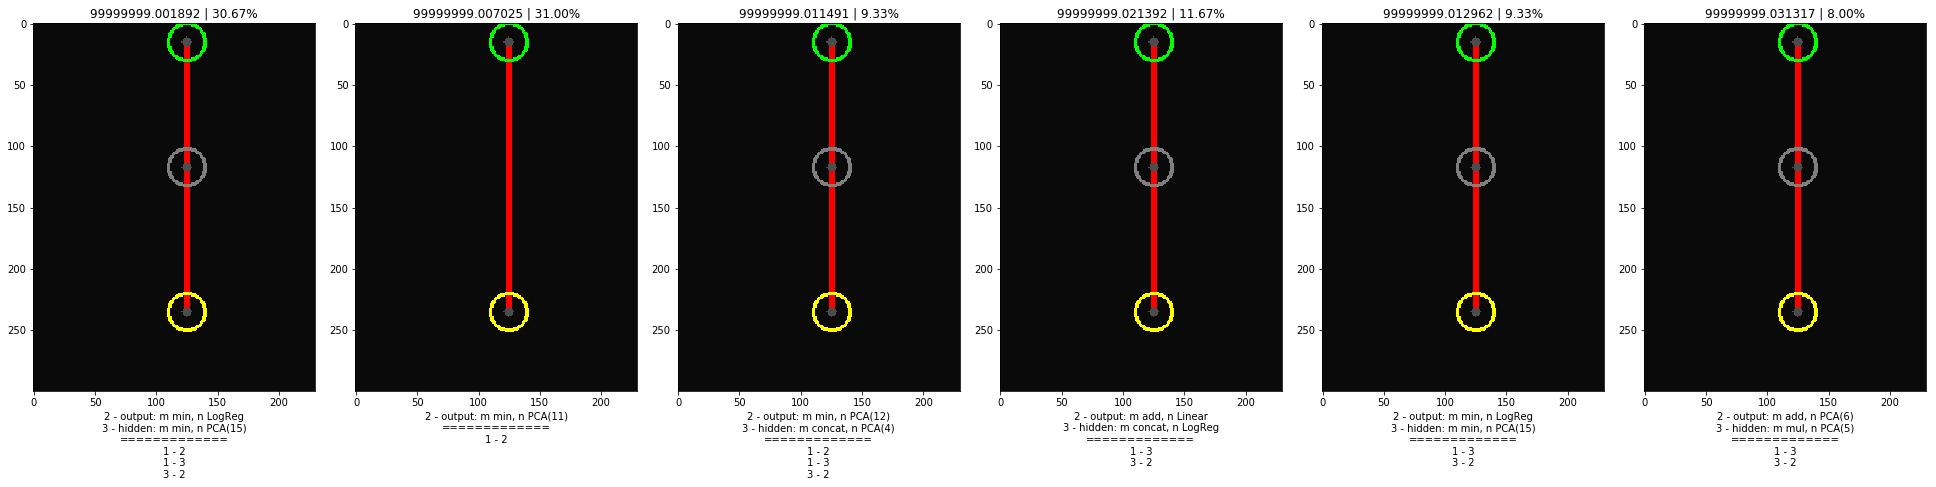

Evaluated: 840 CTresh: 1.250 Species: 6 Last fitness: 99999999.191 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:27) / 30.7 individuals/s

NEW RECORD!
Evaluations: 843 Fitness: 99999999.00117561
-------- nodes -------- 
[2, 'output', {'mm': 'min', 'node': PCA(15)}]
-------- links -------- 
[1, 2, {}, 0.1]
----------------------- 
Species Representatives:


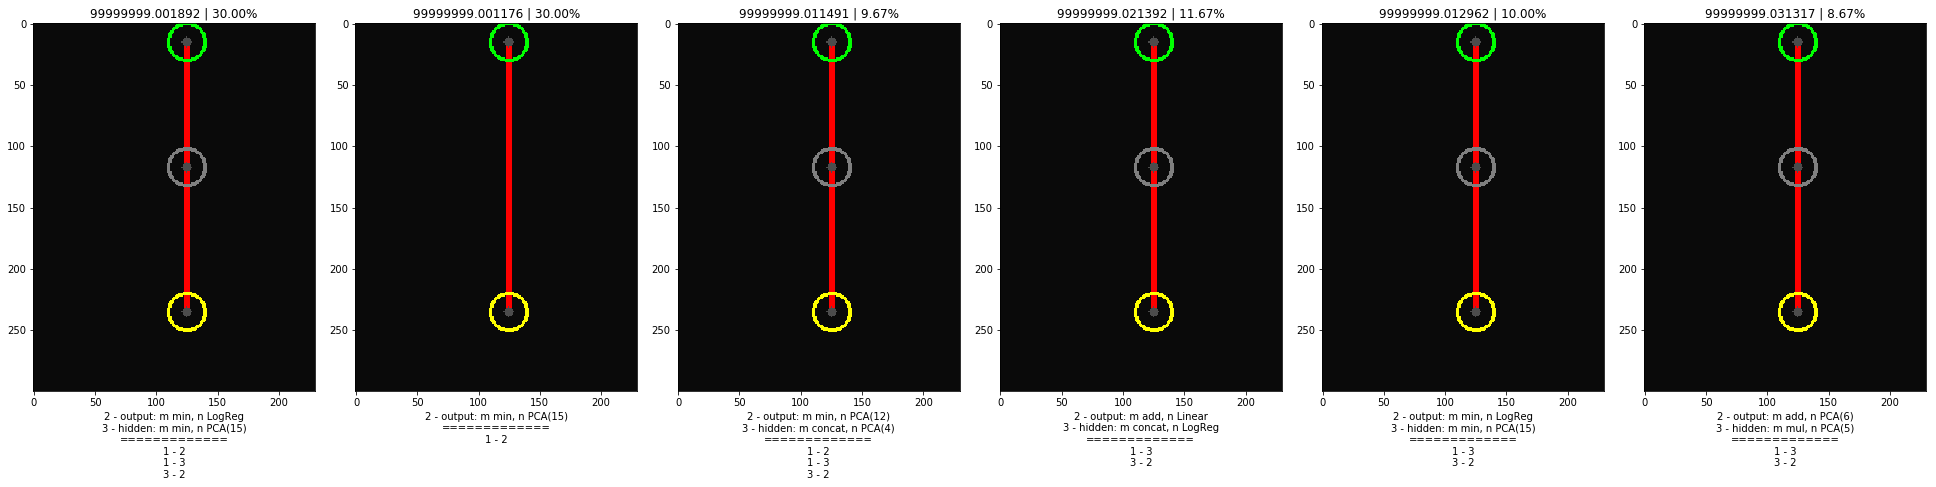

Evaluated: 1075 CTresh: 1.250 Species: 6 Last fitness: 99999999.603 Variance (min/max/mean/std): [] (Elapsed Time: 0:00:35) | 30.0 individuals/s

Client Scheduler: tcp://192.168.0.108:8786 Dashboard: http://192.168.0.108:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GB


In [33]:
# rtNEAT code
try:
    if initeval:
        print('============================================================')
        print("Please wait for the initial evaluation to complete.")
        now = time.time()
        genome_list = []
        for s in pop.Species:
            for i in s.Individuals:
                genome_list.append(i)
        sys.stdout.flush()
        # turn them into NX networks
        grlist = [NEAT.Genome2NX(x) for x in genome_list]
        idlist = [x.GetID() for x in genome_list]
        args = list(zip(idlist,
                        grlist,
                        [fx]*len(grlist),
                        [fy]*len(grlist),
                        ))

        # evaluate all individuals
        fitnesses = [0] * len(grlist)
        vrs = [None] * len(grlist)
        bar = ProgressBar(initial_value=0, max_value=len(grlist))
        cp = [client.submit(evaluate, x) for x in args]
        fff = {}
        for i,ftr in enumerate(as_completed(cp)):
            idx, fitness = ftr.result()
            #fitnesses[idx] = fitness
            fff[idx] = fitness
            bar.update(i)
        bar.finish()
        
        for gnm in genome_list:
            gnm.SetFitness( fff[gnm.GetID()] )
            gnm.SetEvaluated()

        #NEAT.ZipFitness(genome_list, fitnesses)
        print("Evaluation took", '%3.2f' % (time.time() - now), "seconds.")
    else:
        # No initial evaluation, start off with small random fitness
        for s in pop.Species:
            for i in s.Individuals:
                i.SetFitness(np.random.rand()/1000)
        grlist = [NEAT.Genome2NX(x) for x in NEAT.GetGenomeList(pop)]
        idlist = [x.GetID() for x in NEAT.GetGenomeList(pop)]
        args = list(zip(idlist,
                        grlist,
                        [fx]*len(grlist),
                        [fy]*len(grlist),
                        ))
        cp = [client.submit(evaluate, x) for x in args]

    # get best fitness in population and print it
    glist = NEAT.GetGenomeList(pop)
    fitness_list = [x.GetFitness() for x in glist]
    bidx = argmax(fitness_list)
    best = fitness_list[bidx]
    if initeval: evhist.append(decide(best))
    if best > best_ever:
        print('NEW RECORD!')
        print('Evaluations:', 0,
              'Fitness:', decide(best),
              'Species:', len(pop.Species))
        best_gs.append(NEAT.Genome2NX(glist[bidx]))
        print('-------- nodes -------- ')
        print('\n'.join([str(x) for x in glist[bidx].GetNeuronTraits() if x[1] != 'input']))
        print('-------- links -------- ')
        print('\n'.join([str(x) for x in glist[bidx].GetLinkTraits(True)]))
        print('----------------------- ')
        best_ever = best
        if viz:
            species_display(pop)

    print('============================================================')
    print('rtNEAT phase')
    print('============================================================')

    format_custom_text = FormatCustomText('CTresh: %(ctr).3f Species: %(sp)d Last fitness: %(fitness).3f Variance (min/max/mean/std): %(vr)s',
        dict(
            sp=0,
            fitness=0.0,
            vr=str([]),
            ctr=0.0,
        ),)

    widgets = ['Evaluated: ', Counter('%(value)d'), ' ', format_custom_text,
               ' (', Timer(), ') ', RotatingMarker(), FileTransferSpeed(unit='individuals') ]
    bar = ProgressBar(widgets=widgets, initial_value=0, max_value=evaluations)


    # parallel continious loop
    seq = as_completed(cp)
    i=0
    olds = []
    under_evaluation_now = len(cp)
    for f in seq:
        if i >= evaluations:
            [x.cancel() for x in cp]
            break
        if i > 0: bar.update(i)
        i += 1

        # get result from evaluation
        idx, fitness = f.result()
        try:
            if idx not in olds:
                # set that individual's fitness
                pop.AccessGenomeByID(idx).SetFitness(fitness)
                pop.AccessGenomeByID(idx).SetEvaluated()
                under_evaluation_now -= 1

                thegenome = pop.AccessGenomeByID(idx)

                # get best fitness in population and print it
                evhist.append(decide(fitness))
                if fitness > best_ever:
                    print('NEW RECORD!')
                    print('Evaluations:', i,
                          'Fitness:', decide(fitness))
                    best_gs.append(NEAT.Genome2NX(thegenome))
                    print('-------- nodes -------- ')
                    print('\n'.join([str(x) for x in thegenome.GetNeuronTraits() if x[1] != 'input']))
                    print('-------- links -------- ')
                    print('\n'.join([str(x) for x in thegenome.GetLinkTraits(True)]))
                    print('----------------------- ')
                    best_ever = fitness
                    if viz:
                        species_display(pop)
                elif (i%display_pop_each)==0: 
                    if viz:
                        species_display(pop)
                    

            else:
                print(f'Fitness of genome #{idx} was not set.')
                
        except Exception as ex:
            print(ex)
        format_custom_text.update_mapping(fitness=decide(fitness),
                                          sp=len(pop.Species),
                                          ctr=pop.Parameters.CompatTreshold)
        
                
        # apply exploration pressure to species
        if penalize_stangation:
            maxfit = max([x.GetFitness() for x in NEAT.GetGenomeList(pop)])
            for s in pop.Species:
                if s.EvalsNoImprovement > penalize_stagnation_evals:
                    bf = max([x.GetFitness() for x in s.Individuals])
                    # make an exception if that species contains the best genome so far
                    if bf < maxfit:
                        for ind in s.Individuals:
                            ind.SetFitness(0.000000001)

        # create new baby and add to list of tasks
        # only add new babies if the population under evaluation is below N%
        if under_evaluation_now <= (population*(1/3)):
            if not once:
                once=True
                print(f'rtNEAT reproduction cycle started at evaluation #{i}')

            old = NEAT.Genome()
            baby = pop.Tick(old)
            
            for l in baby.LinkGenes: l.Weight = 0.1 # for prettier display    
            
            olds.append(old.GetID())
            newf = client.submit(evaluate, (baby.GetID(),
                                            NEAT.Genome2NX(baby),
                                            fx,
                                            fy,
                                            ))
            seq.add(newf)
            under_evaluation_now += 1
            
except KeyboardInterrupt:
    pass
    
except Exception as ex:
    print(ex)

client.restart(timeout=600)

In [34]:
#client.restart(timeout=600)